In [1]:
# Purpose of this to carry out the following:
    # explore features we already have and create new ones
    # once that is done, carry out an appropriate train/test/validate split - taking temporal validation into account
    # pre processing (impute missingness separately for train/test/validate, normalize, etc)

# The datasets used are the datasets created by build_dataset - they're
# too big for github, so they have been uploaded to google drive. They should
# be downloaded into your local data folder to be imported in this notebook

# The end goal of this notebook is to have our final datasets ready for analysis
# this code should then be moved into our .py files so the notebook can eventually be deleted

In [2]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import config
import os.path
from os import path

#from create_db import create_connection, create_table, clean_column_names
#from populate_db import extract_data, insert_records
#import query_db as qd

import importlib

import datetime
import re
import numpy as np

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Import datasets created in build_dataset

#dataset_main = pd.read_csv('../data/dataset_main.csv')
#dataset_active_sentences = pd.read_csv('../data/active_sentences.csv')
#dataset_main_active_sentences = pd.read_csv('../data/dataset_main_active.csv')

# Just use dataset_main_active

FileNotFoundError: [Errno 2] File b'../data/dataset_main.csv' does not exist: b'../data/dataset_main.csv'

In [23]:
dataset_main_active.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,PRIMARY_OFFENSE_CODE,NextPrefix,NextStart,NextOffense,Time_Diff,Recidivate,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,OFFENSE_CLEAN,sentence_count
0,4,AA,1983-07-12,SELL SCHEDULE II,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,SELL SCHEDULE II,NONE,NaN,0,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,SELL SCHEDULE II,0
1,6,AA,1973-01-30,WORTHLESS CHECK,1973-03-28,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,AB,1973-04-11,WORTHLESS CHECK,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,WORTHLESS CHECK,0
2,6,AB,1973-04-11,WORTHLESS CHECK,1975-08-18,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,NONE,NaN,0,NaN,0.0,0.0,27.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,WORTHLESS CHECK,1
3,8,AA,1990-04-09,DWI DRIVING WHILE IMPAIRED,1990-05-17,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,DWI DRIVING WHILE IMPAIRED,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,DWI DRIVING WHILE IMPAIRED,0
4,8,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,1994-01-26,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,HABITUAL IMPAIRED DRIVING,BA,1995-01-02,HABITUAL IMPAIRED DRIVING,1.0,1.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,HABITUAL IMPAIRED DRIVING,1


In [24]:
dataset_main_active.isnull().sum()

ID                                         0
COMMITMENT_PREFIX                          0
EARLIEST_SENTENCE_EFFECTIVE_DT             0
MOST_SERIOUS_OFFENSE_CODE                  0
END_DATE                                   0
INMATE_RECORD_STATUS_CODE               5853
INMATE_ADMIN_STATUS_CODE                5853
DATE_OF_LAST_INMATE_MOVEMENT            5853
TYPE_OF_LAST_INMATE_MOVEMENT           19702
CONTROL_STATUS                          5853
GENDER                                     0
RACE                                       1
BIRTH_DATE                                 0
STATE_BORN                             30517
ETHNICITY                                702
CITIZENSHIP                              680
PRIMARY_OFFENSE_CODE                   43502
NextPrefix                                 0
NextStart                             457099
NextOffense                                0
Time_Diff                             457099
Recidivate                             32801
INFRACTION

In [ ]:
# Decisions to be made:
    # Which variables to keep?
    # Which features need to be constructed from the available variables?
    # How do we want to deal with missings?
        # e.g. impute? choose majority? some notes here: https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce
        
# A first pass, following this group: https://bucklerd.github.io/MUSA801_Recidivism_Markdown/#
    # Race - keep
    # Sex - keep
    # Age at each sentence - need to calculate using birth date and effective sentence begin date - more indifferent
    # Age category each sentence - keep, look at literature to decide how to categorize
    # Ethnicity - keep
    # Citizenship - keep, but just look at variation, don't include in model
    # Age at first incarceration? Could compute as age at first sentence - keep, similar information to age category
    # Most serious current offense (since there are so many categories, do we want to map on our coded 5 point scale
        # to this..?)
        # - different versions of this (most serious offense, and turn everything else to other), one-hot encoding
        # - with 5 point scale 
    # Current crime violent or not violent (not sure where they are gtting this from, or if its self constructed)
        # - our scale 4-5 to 1, our scale 1-3 is 0 (self-constructed)
        # - feel iffy about this, so also try leaving out
    # Total sentence count - can be computed - lots of bias baked in? - would be at the individual level?
        # - keep, and see how it affects the model (prior history context)
    # Juvenile Offense Flag - would need to construct using age at first incarceration - keep
    # total count of felony and misdemeanor charges - i think these can be calculated from sentence component
        # would be at the individual level not sentence level? 
        # - keep, for the sentence that got a recidivate flag, how many flags in either category
    # custody_class_code - i think this CONTROL_STATUS
        # individual level not sentence level - don't keep (probably adds more bias than value...)
    # special characteristics - i didn't really know how to make sense of this, so i didn't include it for now...
    # - - don't keep (probably adds more bias than value...)
    # total disciplinary infractions - would be at the individual level not the sentence level
        # although this comes from a file that has infraction by date so in theory
        #   we could calculate at the sentence level with some SQL maneouvering 
        # how many infractions between each start/end date of the sentence, but this would be a bit more complicated
    # Type of last inmate movement - we have this, but i'm not sure how much value it adds. also its at the
        # offender level, not sentence level - don't keep 
    

# Thoughts on missingness:
    # Race, Sex, Birth date - basically not missing, can drop or impute couple that are
    # Ethnicity and Citizenship - Majority impute?
    # Most serious current offense - already working on trying to make this less missing
    # Disciplinary infractions - the way this is constructed is by merging on from a file that contains
        # infractions. So i think it is safe to assume that if this variable is missing for an individual,
        # they did not commit any infractions. replace with 0?
    # 
        
    
    

### Decisions:

*First model is most parsimonious
* Bring in median household income and unemployment data so the predictor mechanism isn't just on individual (maybe NC, annual)

### Splitting the work:
* Damini: (pulling via SQL)
    - Disciplinary infractions
    - Most serious current offense
    - Current crime violent
    - Total count of felony and misdemeanor charges
    - Total sentence count
    
* Charmaine:
    - Median HH income
    - Unemployment
    - Age at each sentence - need to calculate using birth date and effective sentence begin date - more indifferent
    - Age category each sentence - keep, look at literature to decide how to categorize
    - Age at first incarceration? Could compute as age at first sentence - keep, similar information to age category
    - Juvenile Offense Flag

### Charmaine's WIP code:

In [25]:
# Check how many observations you have and make sure you don't drop any while creating new features
dataset_main_active.shape

(854115, 33)

In [26]:
# Create AGE_AT_SENTENCE
dataset_main_active['EARLIEST_SENTENCE_EFFECTIVE_DT'] = pd.to_datetime(dataset_main_active['EARLIEST_SENTENCE_EFFECTIVE_DT'], yearfirst=True)
dataset_main_active.loc[dataset_main_active['BIRTH_DATE'] == '0001-01-01', 'BIRTH_DATE'] = np.NaN
dataset_main_active['BIRTH_DATE'] = pd.to_datetime(dataset_main_active['BIRTH_DATE'], format='%Y/%m/%d')

dataset_main_active['age_at_sentence'] = (dataset_main_active['EARLIEST_SENTENCE_EFFECTIVE_DT'] - dataset_main_active['BIRTH_DATE']).astype('<m8[Y]')
dataset_main_active['age_at_sentence'].describe()


count    853909.000000
mean         30.846137
std          10.291193
min         -53.000000
25%          23.000000
50%          29.000000
75%          37.000000
max          90.000000
Name: age_at_sentence, dtype: float64

In [27]:
# Check number of misisng
dataset_main_active['age_at_sentence'].isnull().sum()

206

In [29]:
# Check observations where age is negative
# dataset_main_active.loc[dataset_main_active['age_at_sentence'] < 0, ['EARLIEST_SENTENCE_EFFECTIVE_DT', 'BIRTH_DATE']]

# Convert to NaN if less than 10
dataset_main_active.loc[dataset_main_active['age_at_sentence'] < 10, ['age_at_sentence']] = np.NaN

# Check number of missing
dataset_main_active['age_at_sentence'].isnull().sum()

249

In [30]:
# Create age categories
# Resources: https://www.ussc.gov/research/research-reports/effects-aging-recidivism-among-federal-offenders
dataset_main_active['age_cat'] = pd.cut(dataset_main_active['age_at_sentence'],
                                 bins=[0,17,21,24,29,34,39,44,49,54,59,64,90],
                                 labels=['Under 18', '18-21','22-24','25-29','30-34','35-39','40-44','45-49',
                                        '50-54','55-59','60-64','65 and older',])

In [31]:
dataset_main_active.groupby(['age_cat']).size()

age_cat
Under 18         32502
18-21           140566
22-24           109656
25-29           163449
30-34           132470
35-39           103326
40-44            74276
45-49            48857
50-54            27344
55-59            13121
60-64             5455
65 and older      2844
dtype: int64

In [36]:
dataset_main_active['age_cat'].describe()

count     853866
unique        12
top        25-29
freq      163449
Name: age_cat, dtype: object

In [33]:
# Compute age at first incarceration
first_incarceration = pd.DataFrame(dataset_main_active.groupby(['ID'])['EARLIEST_SENTENCE_EFFECTIVE_DT'].min().reset_index(name='first_incarceration_date'))
dataset_main_active = dataset_main_active.merge(first_incarceration, on='ID')

In [34]:
dataset_main_active[['ID','COMMITMENT_PREFIX','EARLIEST_SENTENCE_EFFECTIVE_DT','first_incarceration_date']].head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,first_incarceration_date
0,4,AA,1983-07-12,1983-07-12
1,6,AA,1973-01-30,1973-01-30
2,6,AB,1973-04-11,1973-01-30
3,8,AA,1990-04-09,1990-04-09
4,8,AB,1993-08-30,1990-04-09


In [35]:
# Flag for juvenile offense
dataset_main_active['age_first_offense'] = (dataset_main_active['first_incarceration_date'] - dataset_main_active['BIRTH_DATE']).astype('<m8[Y]')
dataset_main_active['age_first_offense'].describe()

count    853909.000000
mean         26.495347
std           9.260176
min         -53.000000
25%          19.000000
50%          24.000000
75%          31.000000
max          90.000000
Name: age_first_offense, dtype: float64

In [38]:
# Check observations where age is negative
dataset_main_active.loc[dataset_main_active['age_first_offense'] < 0, ['EARLIEST_SENTENCE_EFFECTIVE_DT', 'BIRTH_DATE']]

,EARLIEST_SENTENCE_EFFECTIVE_DT,BIRTH_DATE
23716,1977-07-07,1992-07-18
38096,1962-05-17,1999-10-29
39173,1976-09-23,1997-09-18
57923,1973-05-21,1999-09-28
63626,1954-11-13,1996-10-08
71025,1973-05-02,1996-10-14
71026,1973-06-29,1996-10-14
101060,1973-05-09,1985-09-20
110046,1946-03-10,1998-09-15
149985,1986-11-19,1986-12-24


In [ ]:
#dataset_main[dataset_main['age_first_offense'] < 10].count()

In [39]:
import matplotlib.pyplot

dataset_main_active.hist(column=['age_first_offense'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11eb34ac8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125512588>]],
      dtype=object)

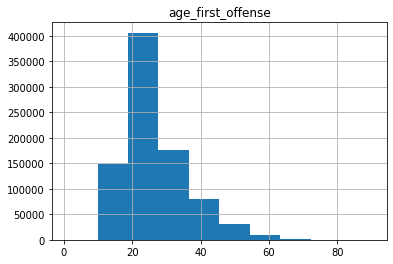

In [40]:
dataset_main_active[dataset_main_active['age_first_offense'] > 0].hist(column=['age_first_offense'])

In [41]:
# Convert to NaN if less than 10
dataset_main_active.loc[dataset_main_active['age_first_offense'] < 10, ['age_first_offense']] = np.NaN

# Check number of misisng
dataset_main_active['age_first_offense'].isnull().sum()

277

In [42]:
dataset_main_active['juv_first_offense'] = (dataset_main_active['age_first_offense'] < 18)
dataset_main_active.sort_values('age_first_offense')[['BIRTH_DATE','first_incarceration_date','age_first_offense', 'juv_first_offense']].head(10)

,BIRTH_DATE,first_incarceration_date,age_first_offense,juv_first_offense
190294,1964-01-20,1974-09-03,10.0,True
40535,1928-03-27,1939-08-20,11.0,True
63763,1961-04-27,1973-04-20,11.0,True
63762,1961-04-27,1973-04-20,11.0,True
63761,1961-04-27,1973-04-20,11.0,True
581154,1987-01-30,1999-08-25,12.0,True
581155,1987-01-30,1999-08-25,12.0,True
104599,1965-06-12,1977-10-18,12.0,True
131543,1967-08-28,1980-12-03,13.0,True
142862,1964-03-24,1978-03-07,13.0,True


In [43]:
#dataset_main_active.loc[dataset_main_active['age_first_offense'] < 10, ['juv_first_offense']] = np.NaN
dataset_main_active['age_first_offense'].isnull().sum()

277

### TO DISCUSS
A lot of these dates don't make sense. How can a toddler be sentenced?

* Replace with NaN if below 10 (talked with Damini about this)
* Maybe impute to mean/median eventually.
* We could trim the data to start at 1976

In [47]:
dataset_main_active[['BIRTH_DATE','first_incarceration_date', 'age_at_sentence', 'age_cat','age_first_offense', 'juv_first_offense']].sample(10)

,BIRTH_DATE,first_incarceration_date,age_at_sentence,age_cat,age_first_offense,juv_first_offense
295394,1959-01-27,1980-09-24,31.0,30-34,21.0,False
816119,1992-11-10,2016-02-09,23.0,22-24,23.0,False
419683,1972-01-13,2001-07-02,29.0,25-29,29.0,False
323155,1945-06-22,1981-10-06,36.0,35-39,36.0,False
764057,1972-04-15,2015-07-14,43.0,40-44,43.0,False
699556,1976-10-12,2004-11-16,28.0,25-29,28.0,False
532688,1974-12-27,1999-03-30,28.0,25-29,24.0,False
38013,1927-03-07,1973-08-29,53.0,50-54,46.0,False
586755,1979-12-11,2006-09-25,26.0,25-29,26.0,False
31138,1938-05-14,1974-05-01,35.0,35-39,35.0,False


### Pull in unemployment data
* Source: BLS LAUS
* Link: https://beta.bls.gov/dataViewer/view/timeseries/LASST370000000000003

In [48]:
dataset_main_active['EARLIEST_SENTENCE_EFFECTIVE_DT'].describe()

count                  854115
unique                  16366
top       2009-01-12 00:00:00
freq                      217
first     1921-09-30 00:00:00
last      2020-04-24 00:00:00
Name: EARLIEST_SENTENCE_EFFECTIVE_DT, dtype: object

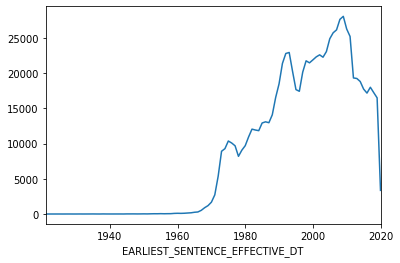

In [49]:
dataset_main_active.groupby([dataset_main_active['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year]).size().plot(kind="line")

The earliest data BLS has only goes to 1976...
### TO DISCUSS
Should we restrict our data to 1976? We would end up dropping 5% of our data. 

Or 1984? (see median HH income data limitations below...)

### DECIDED: 
Trim data to start in 1976

In [50]:
# Import downloaded CSV
unemployment = pd.read_csv('../data/unemployment_nc.csv')

In [51]:
unemployment.head()

,Series ID,Year,Period,Label,Value
0,LASST370000000000003,1976,M01,1976 Jan,6.5
1,LASST370000000000003,1976,M02,1976 Feb,6.5
2,LASST370000000000003,1976,M03,1976 Mar,6.4
3,LASST370000000000003,1976,M04,1976 Apr,6.3
4,LASST370000000000003,1976,M05,1976 May,6.1


In [52]:
unemployment['month'] = unemployment['Period'].str[1:]
unemployment['Year'] = unemployment['Year'].astype(str)
unemployment['date_to_merge'] = unemployment['Year'].str.cat(unemployment['month'], sep ="-")
unemployment['date_to_merge'].head()

0    1976-01
1    1976-02
2    1976-03
3    1976-04
4    1976-05
Name: date_to_merge, dtype: object

In [53]:
# Create a str column to merge on
dataset_main_active['date_to_merge'] = dataset_main_active['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.strftime('%Y-%m')

# Rename variables 
unemployment = unemployment.rename(columns={"Value": "unemp_rate"})
unemployment_limited = unemployment[['date_to_merge','unemp_rate']]

# Merge with unemployment data
dataset_main_active = dataset_main_active.merge(unemployment_limited, on='date_to_merge', how='left')
check_cols = ['EARLIEST_SENTENCE_EFFECTIVE_DT','date_to_merge','unemp_rate']
dataset_main_active[check_cols].sample(10)

,EARLIEST_SENTENCE_EFFECTIVE_DT,date_to_merge,unemp_rate
102127,1993-04-27,1993-04,5.4
830819,2017-10-25,2017-10,4.3
752091,2013-05-30,2013-05,8.2
115217,1997-01-14,1997-01,3.9
30813,1999-08-09,1999-08,3.3
8256,1976-06-17,1976-06,5.9
137099,1988-08-29,1988-08,3.5
297976,2002-11-18,2002-11,6.5
841624,2008-10-16,2008-10,6.5
160374,2001-05-07,2001-05,5.1


In [54]:
# Check how many are missing
dataset_main_active['unemp_rate'].isnull().sum() / dataset_main_active.shape[0]

0.050020196343583706

### Pull in median household income
* Source: Table H-8
* Links: 
  * https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html
  * https://fred.stlouisfed.org/series/MEHOINUSA672N
* Note: Only has 1984-2018?

### DECIDED: DO NOT USE

In [ ]:
#hh_inc = pd.read_excel('../data/h08.xls', sheet_name='edited', usecols=['Year','Median HH Income'], nrows=38)

In [ ]:
#hh_inc

#### Source: https://www.census.gov/topics/income-poverty/income/guidance/cps-historic-footnotes.html

36.	Beginning with 2009 income data, the Census Bureau expanded the upper income interval used to calculate medians and Gini indexes to \\$250,000 or more. Medians falling in the upper open-ended interval are plugged with "\\$250,000." Before 2009, the upper open-ended interval was \\$100,000 and a plug of "\\$100,000" was used.

37.	Implementation of Census 2010-based population controls.

38.	The 2014 CPS ASEC included redesigned questions for income and health insurance coverage. All of the approximately 98,000 addresses were eligible to receive the redesigned set of health insurance coverage questions. The redesigned income questions were implemented to a subsample of the 98,000 addresses using a probability split panel design. Approximately 68,000 addresses were eligible to receive a set of income questions similar to those used in the 2013 CPS ASEC and the remaining 30,000 addresses were eligible to receive the redesigned income questions. The source of these 2013 estimates is the portion of the CPS ASEC sample which received the income questions consistent with the 2013 CPS ASEC, approximately 68,000 addresses.

39.	The source of these 2013 estimates is the portion of the CPS ASEC sample which received the redesigned income questions, approximately 30,000 addresses.

40.	Implementation of an updated CPS ASEC processing system.

We have duplicates of 2013 and 2017, so footnotes 38, 39, and 40 are the most relevant. 

#### Decision: Which duplicates do we use?
- Should we drop the (40) version of 2017? And use the updated version? 
- Should we drop the (39) version of 2013? To be consistent with the decision above to use the updated system.

In [ ]:
# Drop duplicate rows and convert to string
#hh_inc_edit = hh_inc.copy()
#hh_inc_edit['Year'] = hh_inc_edit['Year'].astype(str)
#hh_inc_edit = hh_inc_edit.drop(axis=0, index=[2,6]) # Drop (39) and (40) versions of 2013 and 2017

# Slice string to only keep numbers
#hh_inc_edit['Year'] = hh_inc_edit['Year'].str[:4]
#hh_inc_edit.head()

In [ ]:
# Create a str column to merge on
#dataset_main['year_to_merge'] = dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.strftime('%Y')

# Rename variable
#hh_inc_edit = hh_inc_edit.rename(columns={"Year": "year_to_merge"})

# Merge with dataset_main
#dataset_main = dataset_main.merge(hh_inc_edit, on='year_to_merge', how='left')
#check_cols = ['EARLIEST_SENTENCE_EFFECTIVE_DT','year_to_merge','Median HH Income']
#dataset_main[check_cols].sample(10)

In [ ]:
# Drop merging variables
#dataset_main.drop(axis=1, columns=['year_to_merge', 'date_to_merge'], inplace=True)
#dataset_main.head()

In [ ]:
# Keep features to merge on 
#features_to_add = ['ID', 'COMMITMENT_PREFIX', 'age_at_sentence', 'age_cat', 'juv_first_offense','unemp_rate']
#age_unemp_features = dataset_main[features_to_add]

In [ ]:
#age_unemp_features.head()
#age_unemp_features.shape

### Pipeline Steps

1. **Read Data.**
Load the data. Your function for reading in data can be as simple as calling pd.read_csv. If this step is more complicated (e.g. in your projects), you will want to write more detailed functions.

2. **Explore Data.**
Automate common exploratory tasks. This can include generating distributions of variables, correlations between them, identifying outliers, summarizing by groups, identifying the time range of the data, etc. Feel free to leverage your work from previous labs and Step 1 above.

3. **Create Training and Testing Sets.**
Create training and testing splits. You should use a separate training set, validation set (to tune hyperparameters), and testing set to perform cross-validation.

4. **Pre-Process Data.**
Automate pre-processing steps. One function should impute missing values of continuous variables using the median value and the other should normalize continuous variables.
    * No need to impute BIRTH_DATE, but we can impute AGE variables with median
    * Majority-vote for juvenile flag
    * Disciplinary infractions
        * Missing should be converted to 0
    * Most serious current offense - should not be missing
        * Limit to certain number categories (e.g., top vs other), before train/test/split becuase not imputing.
        * For version where we map on our scales, will be missing 5% of the time, imputed with most common category after train/test/split
    * Current crime violent - will be missing in places
        * Will either be missing or will be in our scale
        * Impute with most common after train/test split 
    * Total count of felony and misdemeanor charges - might be missing
        * Impute with median after train/test/split
    * Total sentence count - shouldn't be missing 


5. **Generate Features.**
Faciliate feature generation. One function should perform one-hot encoding of categorical variables (e.g. with pd.get_dummies) and one function should discretize continuous variables (e.g. with pd.cut). Discretizing continuous variables can be useful in cases where the variable has a significant cutoff value (for example, age could be discretized to distinguish between children under 18 and adults 18 and older).

6. **Build Classifiers.**
Apply machine learning models to a dataset. The function should also print the amount of time required to train each model. 

7. **Evaluate Classifiers.**
Calculate the accuracy of your models based on your testing set, and validate models. 

## Damini's WIP Code

In [5]:
import pandas as pd

In [6]:
dataset_main_active = pd.read_csv('../data/dataset_main_active.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (20,21,22,29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# temporary until re run build data
dataset_main_active.loc[dataset_main_active['NextPrefix']==0,'NextPrefix'] = "NONE"
dataset_main_active.loc[dataset_main_active['NextPrefix']=="0",'NextPrefix'] = "NONE"

In [8]:
dataset_main_active.dtypes

ID                                      int64
COMMITMENT_PREFIX                      object
EARLIEST_SENTENCE_EFFECTIVE_DT         object
MOST_SERIOUS_OFFENSE_CODE              object
INMATE_COMPUTATION_STATUS_FLAG         object
END_DATE                               object
PROJ_END_DATE                          object
INMATE_RECORD_STATUS_CODE              object
INMATE_ADMIN_STATUS_CODE               object
DATE_OF_LAST_INMATE_MOVEMENT           object
TYPE_OF_LAST_INMATE_MOVEMENT           object
CURRENT_COMMITMENT_PREFIX              object
CONTROL_STATUS                         object
GENDER                                 object
RACE                                   object
BIRTH_DATE                             object
STATE_BORN                             object
ETHNICITY                              object
CITIZENSHIP                            object
PRIMARY_OFFENSE_CODE                   object
NextPrefix                             object
NextStart                         

In [9]:
dataset_main_active.rename(columns={"('Count', 'FELON')":'felon_count',"('Count', 'MISD.')":'misd_count'}, inplace=True)


In [10]:
dataset_main_active.columns

Index(['ID', 'COMMITMENT_PREFIX', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'MOST_SERIOUS_OFFENSE_CODE', 'INMATE_COMPUTATION_STATUS_FLAG',
       'END_DATE', 'PROJ_END_DATE', 'INMATE_RECORD_STATUS_CODE',
       'INMATE_ADMIN_STATUS_CODE', 'DATE_OF_LAST_INMATE_MOVEMENT',
       'TYPE_OF_LAST_INMATE_MOVEMENT', 'CURRENT_COMMITMENT_PREFIX',
       'CONTROL_STATUS', 'GENDER', 'RACE', 'BIRTH_DATE', 'STATE_BORN',
       'ETHNICITY', 'CITIZENSHIP', 'PRIMARY_OFFENSE_CODE', 'NextPrefix',
       'NextStart', 'NextOffense', 'new_col', 'Time_Diff', 'Recidivate',
       'INFRACTION_PER_SENT', 'felon_count', 'misd_count',
       'Primary offense code_x', 'Description (if needed)_x',
       'Recidivate_Risk_Level', 'Needed a check?_x',
       'Recidivate_Risk_Level_Lenient', 'Recidivate_Risk_Level_Harsh',
       'Primary offense code_y', 'Description (if needed)_y',
       'Current_Offense_Risk_Level', 'Needed a check?_y',
       'Current_Offense_Risk_Level_Lenient',
       'Current_Offense_Risk_Level_

In [11]:
dataset_main_active = dataset_main_active.loc[:,['ID', 'COMMITMENT_PREFIX', 'EARLIEST_SENTENCE_EFFECTIVE_DT','MOST_SERIOUS_OFFENSE_CODE','END_DATE', 'INMATE_RECORD_STATUS_CODE','INMATE_ADMIN_STATUS_CODE', 'DATE_OF_LAST_INMATE_MOVEMENT','TYPE_OF_LAST_INMATE_MOVEMENT','CONTROL_STATUS', 'GENDER', 'RACE', 'BIRTH_DATE', 'STATE_BORN','ETHNICITY', 'CITIZENSHIP', 'PRIMARY_OFFENSE_CODE', 'NextPrefix','NextStart', 'NextOffense', 'Time_Diff', 'Recidivate','INFRACTION_PER_SENT', 'misd_count','felon_count','Recidivate_Risk_Level', 'Recidivate_Risk_Level_Lenient', 'Recidivate_Risk_Level_Harsh','Current_Offense_Risk_Level','Current_Offense_Risk_Level_Lenient','Current_Offense_Risk_Level_Harsh']]


In [12]:
pd.set_option('display.max_columns', None)

In [13]:
dataset_main_active.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,PRIMARY_OFFENSE_CODE,NextPrefix,NextStart,NextOffense,Time_Diff,Recidivate,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh
0,4,AA,1983-07-12,SELL SCHEDULE II,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,SELL SCHEDULE II,NONE,NaN,0,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0
1,6,AA,1973-01-30,WORTHLESS CHECK,1973-03-28,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,AB,1973-04-11,WORTHLESS CHECK,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,6,AB,1973-04-11,WORTHLESS CHECK,1975-08-18,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,NONE,NaN,0,NaN,0.0,0.0,27.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,8,AA,1990-04-09,DWI DRIVING WHILE IMPAIRED,1990-05-17,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,DWI DRIVING WHILE IMPAIRED,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
4,8,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,1994-01-26,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,HABITUAL IMPAIRED DRIVING,BA,1995-01-02,HABITUAL IMPAIRED DRIVING,1.0,1.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0


## Steps to follow for features:
    - Stage 0: constructing variables, understanding weirdness and outliers
    - Stage 1: train/test/validate/active split
    - Stage 2: pre-process - including imputing messiness for vars created in Stage 0, and creating variables based on those (e.g. once Age has been imputed, construct Age_cat)
    

### Disciplinary infractions
- Stage 0: constructed in build_dataset, missings replaced with 0 - no infractions assumed if ID not found in   infractions dataset
- Stage 2: Normalization of continuous var required


### Most serious current offense
- Stage 0 (v1): Construct more generalized var which captures X% of offenses, turning all else to others
- Stage 2 (v1): There should be no missingness (double check this) - will need one-hot encoding
    
- Stage 0 (v2): (alt var - scale coded by us): Already merged, nothing further needed
- Stage 2 (v2): there will be missings (since we only coded 95% of offenses) so fill NA with majority then one-hot


In [14]:
# Most serious current offense v1
#most_offenses = dataset_main_active.groupby("MOST_SERIOUS_OFFENSE_CODE").size().reset_index(name="count")
most_offenses = dataset_main_active.groupby("MOST_SERIOUS_OFFENSE_CODE")['ID'].size().reset_index(name="count")
most_offenses['PCT'] = most_offenses['count'] / dataset_main_active.shape[0]
most_offenses = most_offenses.sort_values(by='PCT', ascending=False)
most_offenses['CUMSUM'] = most_offenses['PCT'].cumsum()

most_offenses['OFFENSE_CLEAN'] = most_offenses['MOST_SERIOUS_OFFENSE_CODE']
most_offenses.loc[most_offenses['CUMSUM'] > 0.9,'OFFENSE_CLEAN'] = "OTHER"
most_offenses = most_offenses.loc[:,['MOST_SERIOUS_OFFENSE_CODE','OFFENSE_CLEAN']]

# Merge this back onto main dataset
dataset_main_active = dataset_main_active.merge(most_offenses, how="left", on="MOST_SERIOUS_OFFENSE_CODE")

In [15]:
dataset_main_active.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,PRIMARY_OFFENSE_CODE,NextPrefix,NextStart,NextOffense,Time_Diff,Recidivate,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,OFFENSE_CLEAN
0,4,AA,1983-07-12,SELL SCHEDULE II,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,SELL SCHEDULE II,NONE,NaN,0,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,SELL SCHEDULE II
1,6,AA,1973-01-30,WORTHLESS CHECK,1973-03-28,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,AB,1973-04-11,WORTHLESS CHECK,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,WORTHLESS CHECK
2,6,AB,1973-04-11,WORTHLESS CHECK,1975-08-18,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,NONE,NaN,0,NaN,0.0,0.0,27.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,WORTHLESS CHECK
3,8,AA,1990-04-09,DWI DRIVING WHILE IMPAIRED,1990-05-17,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,DWI DRIVING WHILE IMPAIRED,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,DWI DRIVING WHILE IMPAIRED
4,8,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,1994-01-26,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,HABITUAL IMPAIRED DRIVING,BA,1995-01-02,HABITUAL IMPAIRED DRIVING,1.0,1.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,HABITUAL IMPAIRED DRIVING


### Current Crime Violent Flag
- Stage 0 (v1): don't include variable (we dont have it)
- Stage 2 (v1): dont include variable (we dont have it)
    
- Stage 0 (v2 - scale coded by us): Already merged, nothing further needed
- Stage 2: there will be missings (since we only coded 95% of offenses) so fill NA with majority then categorize as 1 for receiving score 4 or 5 and 0 otherwise


### Total count of felony and misdemeanor charges
- Stage 0: merged and created, nothing further needed
- Stage 2: impute NAs with median (very few missing) then normalize since continuous var


### Total sentence count
- Stage 0: construct
- Stage 2: shouldnt be missing (check) - then normalize since continuous var


In [16]:
count = dataset_main_active.groupby(['ID','COMMITMENT_PREFIX']).count().groupby(level=0).cumsum().reset_index()
count['sentence_count'] = count['EARLIEST_SENTENCE_EFFECTIVE_DT'] - 1
count = count.loc[:,['ID','COMMITMENT_PREFIX','sentence_count']]
dataset_main_active = dataset_main_active.merge(count, how="left", on = ['ID','COMMITMENT_PREFIX'])


In [56]:
dataset_main_active.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,PRIMARY_OFFENSE_CODE,NextPrefix,NextStart,NextOffense,Time_Diff,Recidivate,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,OFFENSE_CLEAN,sentence_count,age_at_sentence,age_cat,first_incarceration_date,age_first_offense,juv_first_offense,date_to_merge,unemp_rate
0,4,AA,1983-07-12,SELL SCHEDULE II,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,SELL SCHEDULE II,NONE,NaN,0,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,SELL SCHEDULE II,0,21.0,18-21,1983-07-12,21.0,False,1983-07,9.0
1,6,AA,1973-01-30,WORTHLESS CHECK,1973-03-28,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,AB,1973-04-11,WORTHLESS CHECK,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,WORTHLESS CHECK,0,21.0,18-21,1973-01-30,21.0,False,1973-01,NaN
2,6,AB,1973-04-11,WORTHLESS CHECK,1975-08-18,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,NONE,NaN,0,NaN,0.0,0.0,27.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,WORTHLESS CHECK,1,21.0,18-21,1973-01-30,21.0,False,1973-04,NaN
3,8,AA,1990-04-09,DWI DRIVING WHILE IMPAIRED,1990-05-17,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,DWI DRIVING WHILE IMPAIRED,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,DWI DRIVING WHILE IMPAIRED,0,26.0,25-29,1990-04-09,26.0,False,1990-04,3.7
4,8,AB,1993-08-30,HABITUAL IMPAIRED DRIVING,1994-01-26,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,HABITUAL IMPAIRED DRIVING,BA,1995-01-02,HABITUAL IMPAIRED DRIVING,1.0,1.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,HABITUAL IMPAIRED DRIVING,1,29.0,25-29,1990-04-09,26.0,False,1993-08,4.8


In [18]:
#dataset_main_active_subset.isnull().sum()

# Next Steps:
- Train/test/validate/active split
- Write functions to conduct stage 2 for the above vars

## Stratified Sampling For Train Test Validate Split

In [101]:
subset = ['ID','COMMITMENT_PREFIX','EARLIEST_SENTENCE_EFFECTIVE_DT','MOST_SERIOUS_OFFENSE_CODE','END_DATE','INMATE_ADMIN_STATUS_CODE','CONTROL_STATUS','GENDER','RACE','ETHNICITY','INFRACTION_PER_SENT','misd_count','felon_count','Recidivate_Risk_Level','Recidivate_Risk_Level_Lenient','Recidivate_Risk_Level_Harsh','Current_Offense_Risk_Level','Current_Offense_Risk_Level_Lenient','Current_Offense_Risk_Level_Harsh','OFFENSE_CLEAN','sentence_count','NextPrefix']
age_unemp_features = ['age_at_sentence', 'age_cat', 'juv_first_offense','unemp_rate', 'date_to_merge']
subset.extend(age_unemp_features)
#age_unemp_features = dataset_main[features_to_add]
dataset_main_active_subset = dataset_main_active.loc[:,subset] 

#dataset_main_active_subset = dataset_main_active.copy()
#dataset_main_active_subset.reset_index(drop=True,inplace=True)

In [102]:
dataset_main_active_subset.columns

Index(['ID', 'COMMITMENT_PREFIX', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'MOST_SERIOUS_OFFENSE_CODE', 'END_DATE', 'INMATE_ADMIN_STATUS_CODE',
       'CONTROL_STATUS', 'GENDER', 'RACE', 'ETHNICITY', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'Recidivate_Risk_Level',
       'Recidivate_Risk_Level_Lenient', 'Recidivate_Risk_Level_Harsh',
       'Current_Offense_Risk_Level', 'Current_Offense_Risk_Level_Lenient',
       'Current_Offense_Risk_Level_Harsh', 'OFFENSE_CLEAN', 'sentence_count',
       'NextPrefix', 'age_at_sentence', 'age_cat', 'juv_first_offense',
       'unemp_rate', 'date_to_merge'],
      dtype='object')

In [103]:
# Trim data to start in 1976
dataset_main_active_subset = dataset_main_active_subset[dataset_main_active_subset['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year >= 1976]
dataset_main_active_subset['EARLIEST_SENTENCE_EFFECTIVE_DT'].describe()

count                  811392
unique                  12620
top       2009-01-12 00:00:00
freq                      217
first     1976-01-01 00:00:00
last      2020-04-24 00:00:00
Name: EARLIEST_SENTENCE_EFFECTIVE_DT, dtype: object

In [104]:
dataset_main_active_subset.shape

(811392, 27)

In [105]:
# Add time fixed effects (year-month)
dataset_main_active_subset.rename(columns={'date_to_merge': 'year_month'}, inplace=True)
dataset_main_active_subset['year_month'].sample(10)

735404    2012-07
180237    1999-04
563688    2005-11
505232    2012-12
639837    2001-07
682249    2008-09
613718    2018-09
573546    2000-04
307997    1987-10
205635    1994-12
Name: year_month, dtype: object

In [ ]:
# Drop if race / sex / ethnicity is missing
dataset_main_active_subset.isnull()

In [106]:
# hold out active sentences
active_sentences = dataset_main_active_subset[(dataset_main_active_subset['INMATE_ADMIN_STATUS_CODE']=='ACTIVE') & (dataset_main_active_subset['NextPrefix']=="NONE") ]
print("Size of active sentences dataset: ",active_sentences.shape[0])

Size of active sentences dataset:  32711


In [107]:
# Drop those missing decided category
dataset_no_active = dataset_main_active_subset[(dataset_main_active_subset['Recidivate_Risk_Level'].notnull())]
print("Dataset size: " , dataset_no_active.shape[0])

Dataset size:  778681


In [108]:
dataset_no_active.head(2)

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,END_DATE,INMATE_ADMIN_STATUS_CODE,CONTROL_STATUS,GENDER,RACE,ETHNICITY,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,OFFENSE_CLEAN,sentence_count,NextPrefix,age_at_sentence,age_cat,juv_first_offense,unemp_rate,year_month
0,4,AA,1983-07-12,SELL SCHEDULE II,1984-07-11,INACTIVE,REGULAR POPULATION RPOP,MALE,WHITE,UNKNOWN,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,SELL SCHEDULE II,0,NONE,21.0,18-21,False,9.0,1983-07
3,8,AA,1990-04-09,DWI DRIVING WHILE IMPAIRED,1990-05-17,INACTIVE,REGULAR POPULATION RPOP,MALE,WHITE,UNKNOWN,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,DWI DRIVING WHILE IMPAIRED,0,AB,26.0,25-29,False,3.7,1990-04


In [109]:
import datetime

In [110]:
holdOut = 0.2
randomState = 1234


In [ ]:
#dataset_no_active = dataset_no_active_backup
#dataset_no_active_backup = dataset_no_active

In [111]:
# Train, val, test split:
start = datetime.datetime.now()

# get number of unique ids and the uniqe IDs
n_ID = len(dataset_no_active.ID.unique())
ids = pd.DataFrame(dataset_no_active.ID.unique())

# sample from IDs
train_index = ids.sample(round(n_ID*(1-holdOut)),random_state = randomState ).values.tolist()
train_index = [item for sublist in train_index for item in sublist]
# train data is data from any IDs that show up in train index
train_val = dataset_no_active[dataset_no_active['ID'].isin(train_index)]
# test data is data from any IDs that don't show up in train index
test_data = dataset_no_active[~dataset_no_active['ID'].isin(train_index)]

# repeat similar process for validate data
n_ID = len(train_val.ID.unique())
ids = pd.DataFrame(train_val.ID.unique())

# sample from IDs
train_index = ids.sample(round(n_ID*(1-holdOut)),random_state = randomState ).values.tolist()
train_index = [item for sublist in train_index for item in sublist]
# train data is data from any IDs that show up in train index
train_data = train_val[train_val['ID'].isin(train_index)]
# test data is data from any IDs that don't show up in train index
validate_data = train_val[~train_val['ID'].isin(train_index)]

stop = datetime.datetime.now()
print("Time Elapsed:", stop - start)  


Time Elapsed: 0:00:02.947093


In [112]:
train_data.shape

(498138, 27)

In [113]:
test_data.shape

(155550, 27)

In [114]:
validate_data.shape

(124993, 27)

In [115]:
# Sanity check

print("Total Number of Unique IDs:" , len(dataset_no_active.ID.unique()))
print("Total Number of IDs in Test Data:" , len(test_data.ID.unique()))
print("Total Number of IDs in Train Data:" , len(train_data.ID.unique()))
print("Total Number of IDs in Validate Data:" , len(validate_data.ID.unique()))

print("Do the IDs add up?" , len(test_data.ID.unique()) + len(train_data.ID.unique()) +  len(validate_data.ID.unique()) ==  len(dataset_no_active.ID.unique()))

print("Does Test Represent 20% of the data?", (len(test_data.ID.unique())/len(dataset_no_active.ID.unique())) == holdOut)
print("Test Represents X% of the data:", (len(test_data.ID.unique())/len(dataset_no_active.ID.unique())))
print("Does Train+Validate Represent 80% of the data?", len(train_data.ID.unique())+len(validate_data.ID.unique())/len(dataset_no_active.ID.unique()) == (1-holdOut))
print("Train+Validate Represents X% of the data:", (len(train_data.ID.unique())+len(validate_data.ID.unique()))/len(dataset_no_active.ID.unique()))
print("Does Validate Represent 20% of the Train+Validate Data?:", len(validate_data.ID.unique())/(len(train_data.ID.unique())+len(validate_data.ID.unique())))
print("Does Train Represent 80% of the Train+Validate Data?:", len(train_data.ID.unique())/(len(train_data.ID.unique())+len(validate_data.ID.unique())))


Total Number of Unique IDs: 419118
Total Number of IDs in Test Data: 83824
Total Number of IDs in Train Data: 268235
Total Number of IDs in Validate Data: 67059
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.20000095438516122
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.7999990456148388
Does Validate Represent 20% of the Train+Validate Data?: 0.20000059649143737
Does Train Represent 80% of the Train+Validate Data?: 0.7999994035085627


In [116]:
# Sanity Check #2 - how representative are our datasets compared to the overall dataset
dataset_no_active.describe()

,ID,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,sentence_count,age_at_sentence,unemp_rate
count,7.786810e+05,778681.000000,778640.000000,778640.000000,778681.000000,778681.000000,778681.000000,742593.000000,742593.000000,742593.000000,778681.000000,778631.000000,778681.000000
mean,5.031142e+05,3.345090,0.870663,1.016188,0.393662,0.326353,0.471062,2.311892,1.966943,2.707653,1.068534,30.888056,5.856456
std,3.744384e+05,11.879795,1.534316,1.175044,0.964090,0.817424,1.147630,1.055669,0.975501,1.209166,1.640842,10.176356,2.125382
min,4.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,3.000000
25%,2.071150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,23.000000,4.400000
50%,4.170590e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,0.000000,29.000000,5.300000
75%,7.258430e+05,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,4.000000,2.000000,37.000000,6.500000
max,1.638741e+06,1009.000000,125.000000,48.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,42.000000,90.000000,12.200000


In [117]:
test_data.describe()

,ID,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,sentence_count,age_at_sentence,unemp_rate
count,1.555500e+05,155550.000000,155543.000000,155543.000000,155550.000000,155550.000000,155550.000000,148359.000000,148359.000000,148359.000000,155550.000000,155535.000000,155550.000000
mean,5.050098e+05,3.305728,0.871482,1.018458,0.392009,0.324468,0.469412,2.314871,1.968819,2.710762,1.067856,30.906175,5.861931
std,3.744809e+05,11.492662,1.553164,1.175424,0.961965,0.814066,1.146440,1.056503,0.975984,1.210525,1.653982,10.183050,2.128535
min,8.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,3.000000
25%,2.086458e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,23.000000,4.400000
50%,4.195945e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,0.000000,29.000000,5.300000
75%,7.274230e+05,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,4.000000,2.000000,37.000000,6.500000
max,1.638691e+06,557.000000,66.000000,37.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,90.000000,12.200000


In [118]:
train_data.describe()

,ID,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,sentence_count,age_at_sentence,unemp_rate
count,4.981380e+05,498138.000000,498112.000000,498112.000000,498138.000000,498138.00000,498138.000000,475138.000000,475138.000000,475138.000000,498138.000000,498107.000000,498138.000000
mean,5.023908e+05,3.336461,0.871067,1.014013,0.394084,0.32699,0.471251,2.312038,1.967369,2.707786,1.067096,30.887679,5.855552
std,3.747577e+05,11.867748,1.526807,1.176535,0.965687,0.81980,1.148407,1.055021,0.975551,1.208164,1.637423,10.172103,2.124009
min,4.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,12.000000,3.000000
25%,2.068120e+05,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,2.000000,0.000000,23.000000,4.400000
50%,4.153430e+05,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,2.000000,2.000000,3.000000,0.000000,29.000000,5.300000
75%,7.256870e+05,2.000000,1.000000,1.000000,0.000000,0.00000,0.000000,3.000000,2.000000,4.000000,2.000000,37.000000,6.500000
max,1.638741e+06,854.000000,103.000000,48.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,42.000000,87.000000,12.200000


In [119]:
validate_data.describe()

,ID,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,sentence_count,age_at_sentence,unemp_rate
count,1.249930e+05,124993.000000,124985.000000,124985.000000,124993.000000,124993.000000,124993.000000,119096.000000,119096.000000,119096.000000,124993.000000,124989.000000,124993.000000
mean,5.036382e+05,3.428464,0.868032,1.022035,0.394038,0.326162,0.472362,2.307601,1.962904,2.703248,1.075108,30.867012,5.853246
std,3.731042e+05,12.390445,1.540564,1.168593,0.960359,0.812100,1.146017,1.057209,0.974696,1.211461,1.638029,10.185006,2.126930
min,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,13.000000,3.000000
25%,2.067120e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,23.000000,4.400000
50%,4.198950e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,0.000000,29.000000,5.300000
75%,7.248660e+05,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,4.000000,2.000000,37.000000,6.500000
max,1.638712e+06,1009.000000,125.000000,29.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,21.000000,83.000000,12.200000


In [120]:
active_sentences.describe()

,ID,INFRACTION_PER_SENT,misd_count,felon_count,Recidivate_Risk_Level,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Current_Offense_Risk_Level,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,sentence_count,age_at_sentence,unemp_rate
count,3.271100e+04,32711.000000,32711.000000,32711.000000,0.0,0.0,0.0,26471.000000,26471.000000,26471.000000,32711.000000,32711.000000,32711.000000
mean,8.987442e+05,20.091376,0.103115,2.232857,NaN,NaN,NaN,3.445544,2.973292,3.779532,1.525022,33.812357,5.134774
std,4.787929e+05,41.593592,0.478750,2.009298,NaN,NaN,NaN,1.181031,1.174308,1.097570,2.049385,11.024137,1.907394
min,8.000000e+01,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,13.000000,3.000000
25%,5.152790e+05,1.000000,0.000000,1.000000,NaN,NaN,NaN,3.000000,2.000000,3.000000,0.000000,25.000000,3.900000
50%,8.957270e+05,6.000000,0.000000,2.000000,NaN,NaN,NaN,3.000000,3.000000,4.000000,1.000000,32.000000,4.300000
75%,1.334804e+06,22.000000,0.000000,3.000000,NaN,NaN,NaN,5.000000,4.000000,5.000000,2.000000,41.000000,5.700000
max,1.638770e+06,989.000000,20.000000,87.000000,NaN,NaN,NaN,5.000000,5.000000,5.000000,27.000000,83.000000,12.200000


In [121]:
# Distributions look pretty good across train,test, and validate compared to dataset minus active
# Active sentences don't look as close (most variables are fine, not Infractions though) but there's no reason 
# currently incarcerated people would be a random sample of historical sentences 

# Next need to check if the date distributions look good
print(dataset_no_active['EARLIEST_SENTENCE_EFFECTIVE_DT'].min())
print(dataset_no_active['EARLIEST_SENTENCE_EFFECTIVE_DT'].max())

print(train_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].min())
print(train_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].max())

print(validate_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].min())
print(validate_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].max())

print(test_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].min())
print(test_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].max())



1976-01-01 00:00:00
2020-04-20 00:00:00
1976-01-01 00:00:00
2020-04-20 00:00:00
1976-01-01 00:00:00
2020-04-20 00:00:00
1976-01-01 00:00:00
2020-04-20 00:00:00


In [122]:
def fix_dates(data,date_var):
    data['new_col'] = data[date_var].astype(str).str[0:4].astype(int)
    data.loc[data['new_col']>2261, date_var] = '2261-01-02'
    data[date_var] = data[date_var].replace(0,np.nan)
    data.loc[data[date_var]=="0", date_var] = None
    data[date_var] = pd.to_datetime(data[date_var],format='%Y-%m-%d',errors='coerce')
    #df[date_var] = pd.to_datetime(df[date_var].str.split(n=1).str[0],format='%Y-%m-%d')
    return data


In [123]:
dataset_no_active = fix_dates(dataset_no_active,'EARLIEST_SENTENCE_EFFECTIVE_DT')

train_data = fix_dates(train_data,'EARLIEST_SENTENCE_EFFECTIVE_DT')
test_data = fix_dates(test_data,'EARLIEST_SENTENCE_EFFECTIVE_DT')
validate_data = fix_dates(validate_data,'EARLIEST_SENTENCE_EFFECTIVE_DT')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [ ]:
#dataset_no_active.dtypes

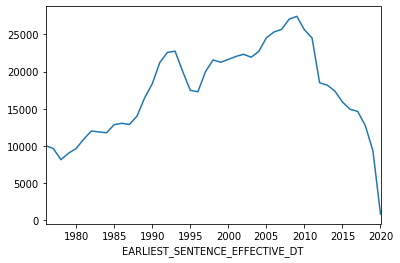

In [124]:
dataset_no_active.groupby([dataset_no_active['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year]).size().plot(kind="line")


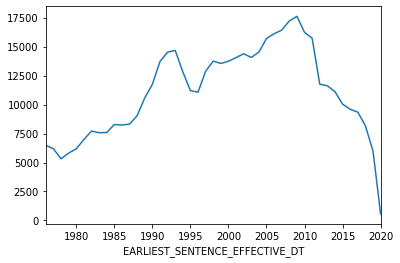

In [127]:
train_data.groupby([train_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year]).size().plot(kind="line")

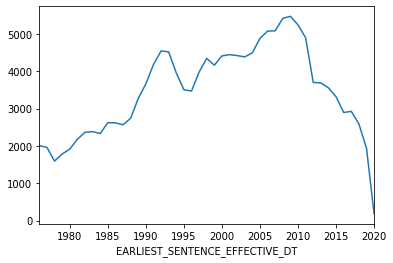

In [125]:
test_data.groupby([test_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year]).size().plot(kind="line")

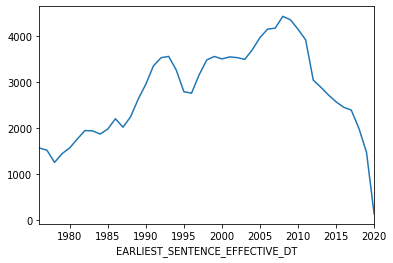

In [126]:
validate_data.groupby([validate_data['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year]).size().plot(kind="line")

In [ ]:
# All the date distributions look pretty good! 

## Pre Processing

In [ ]:
# Final list of features:
    # 1. Race - impute missing with majority in each dataset, then one-hot
    # 2. Sex - impute missing with majority in each dataset, then one-hot
    # 3. Age at sentence - impute missing with median in each dataset. Do we want to normalize?, then create:
        # 13. Age category each sentence - then one-hot?
        # 14. Age at first incarceration? - normalize?
        # 15. Juvenile Offense Flag - binary indicator
    # 4. Ethnicity  - impute missing with majority in each dataset, then one-hot
    # 5. and 6. Most serious current offense 
        # v1: OFFENSE CLEAN (no missing) - one-hot
        # v2: Current Offense Risk Level, Lenient, Harsh (has missing, majority impute) one-hot
    # 7. Disciplinary infractions - normalize?
    # 8. Current crime violent 
        # v1: dont include
        # v2: Current Offense Risk Level, Lenient, Harsh (has missing, majority impute),then categorize  
            # as 1 for receiving score 4 or 5 and 0 otherwise - binary indicator
    # 9. and 10. Total count of felony and misdemeanor charges - normalize?
    # 11. Total sentence count - normalize..?
    # 12. Unemployment - normalize?
    # 16. Control status - impute with majority and one-hot


In [128]:
import pipeline as pl

In [129]:
import importlib

In [130]:
importlib.reload(pl)

<module 'pipeline' from '/Users/charmainerunes/git/covid_decarceration/files/pipeline.py'>

In [131]:
train_data.columns

Index(['ID', 'COMMITMENT_PREFIX', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'MOST_SERIOUS_OFFENSE_CODE', 'END_DATE', 'INMATE_ADMIN_STATUS_CODE',
       'CONTROL_STATUS', 'GENDER', 'RACE', 'ETHNICITY', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'Recidivate_Risk_Level',
       'Recidivate_Risk_Level_Lenient', 'Recidivate_Risk_Level_Harsh',
       'Current_Offense_Risk_Level', 'Current_Offense_Risk_Level_Lenient',
       'Current_Offense_Risk_Level_Harsh', 'OFFENSE_CLEAN', 'sentence_count',
       'NextPrefix', 'age_at_sentence', 'age_cat', 'juv_first_offense',
       'unemp_rate', 'year_month', 'new_col'],
      dtype='object')

In [ ]:
#train_data.head()

In [ ]:
# Race, Sex, ethnicity, Current_Offense_Risk_Level, Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh
categorical_vars_to_impute = ['RACE','GENDER','ETHNICITY', 'CONTROL_STATUS','OFFENSE_CLEAN', 'Current_Offense_Risk_Level', "Current_Offense_Risk_Level_Lenient","Current_Offense_Risk_Level_Harsh"]
#continuous_vars_to_impute = ['INFRACTION_PER_SENT','misd_count','felon_count','sentence_count','age_sentence','unemployment']
continuous_vars_to_impute = ['INFRACTION_PER_SENT','misd_count','felon_count','sentence_count']

# impute categorical vars
train_data = pl.impute_most_common(train_data,categorical_vars_to_impute)
test_data = pl.impute_most_common(test_data,categorical_vars_to_impute)
validate_data = pl.impute_most_common(validate_data,categorical_vars_to_impute)

# impute continuous vars
train_data = pl.impute_missing(train_data,continuous_vars_to_impute)
test_data = pl.impute_missing(test_data,continuous_vars_to_impute)
validate_data = pl.impute_missing(validate_data,continuous_vars_to_impute)

# construct vars depending on those vars

# construct age_cat, age at first_sentence, juvenile_offense flag
dataset_main['age_cat'] = pd.cut(dataset_main['age_at_sentence'],
                                 bins=[0,17,21,24,29,34,39,44,49,54,59,64,90],
                                 labels=['Under 18', '18-21','22-24','25-29','30-34','35-39','40-44','45-49',
                                        '50-54','55-59','60-64','65 and older',])

# construct current crime violent v2
train_data = pl.current_crime_violent(train_data,[4,5])
test_data = pl.current_crime_violent(test_data,[4,5])
validate_data = pl.current_crime_violent(validate_data,[4,5])
    
# then one-hot / normalize
# categorical_vars_one_hot = categorical_vars_to_impute + ['age_cat']
categorical_vars_one_hot = categorical_vars_to_impute
#continuous_vars_normalize = continuous_vars_to_impute + ['age_first_sentence']
continuous_vars_normalize = continuous_vars_to_impute 

train_data = pl.one_hot_encode(train_data,categorical_vars_one_hot)
test_data = pl.one_hot_encode(test_data,categorical_vars_one_hot)
validate_data = pl.one_hot_encode(validate_data,categorical_vars_one_hot)

# def normalize_features(to_norm, train, features):
train_backup = train.copy()
train_data = pl.normalize_features(train_data,train_backup,continuous_vars_normalize)
test_data = pl.normalize_features(test_data,train_backup,continuous_vars_normalize)
validate_data = pl.normalize_features(validate_data,train_backup,continuous_vars_normalize)



## To Do (in no particular order):
- Idk why i'm getting all of these set copy warnings - check if everything is working ok? (Damini - if still happening post re org)
- bringing in age / unemployment features from first half of the notebook (Charmaine - DONE)
- add time fixed effects! month-year? year? (Charmaine - DONE)
- one hot encoding adjustment (i.e. drop from validation / test if they dont appear in training, add empty cols if they appear in training but not test) (Damini)
- trim data at some ppoint BEFORE imputing unemployment to be in line with the correct time frame (Charmaine - DONE)
- once we're reasonably happy with all this, move everything in build_dataset and features_split_preprocess into .py files that can be called on to build the dataset + features in one go, with no intermediate csvs. Then, we can use a jupyter notebook to actually run the analysis (Charmaine and Damini - mostly on Friday)
- build classifiers starting with random forest, decision tree, multinomial regression (C+D on Saturday/sunday)
- i held out the active sentences before doing the train/test split, but need to go back and make sure the relevant pre processing also happens on that dataset (Damini)
- i feel pretty yucky about majority imputing race / sex because its obviously going to be mostly black men. given that demographics arent missing that often, thoughts on dropping observations missing demographics? (right at the onset, before traint/test/validate/active split) (Charmaine)

In [ ]:
#train_data.shape

In [ ]:
#train_data.describe()

In [ ]:
#x = train_data['Current_Offense_Risk_Level'].isin([4,5])

In [ ]:
#x.head()

In [ ]:
#

In [ ]:
#train_data.head()

In [ ]:
#train_data['CONTROL_STATUS'].isnull().sum()

In [ ]:
#train_data.dtypes